In [1]:
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
import sys
import datetime as dt
from cupyx import jit
import cupy
from cupyx.scipy.fft import get_fft_plan
import cupyx.scipy.fft

In [ ]:
starttime = dt.datetime.now()
###
endtime = dt.datetime.now()
(endtime-starttime).microseconds

In [2]:
x = cp.arange(6).reshape(2, 3).astype('f')
print(x.device)
x

<CUDA Device 0>


array([[0., 1., 2.],
       [3., 4., 5.]], dtype=float32)

In [3]:
with cp.cuda.Device(0):
  x_on_gpu1 = cp.array([1, 2, 3, 4, 5])
x_on_gpu1.device

<CUDA Device 0>

In [4]:
x_cpu = x.get()
print(x_cpu)
print(x)

[[0. 1. 2.]
 [3. 4. 5.]]
[[0. 1. 2.]
 [3. 4. 5.]]


In [5]:
def softplus(x):
    xp = cp.get_array_module(x)  # 'xp' is a standard usage in the community
    print("Using:", xp.__name__)
    return xp.maximum(0, x) + xp.log1p(xp.exp(-abs(x)))

In [6]:
squared_diff_generic = cp.ElementwiseKernel(
    'T x, T y',
    'T z',
    '''
        T diff = x - y;
        z = diff * diff;
    ''',
    'squared_diff_generic')

In [10]:
xx = cp.arange(10, dtype=np.float32).reshape(2, 5)
yy = cp.arange(5, dtype=np.float32)
squared_diff_generic(xx,yy)

array([[ 0.,  0.,  0.,  0.,  0.],
       [25., 25., 25., 25., 25.]], dtype=float32)

In [20]:
###??? reduction expression
l2norm_kernel = cp.ReductionKernel(
    'T x',  # input params
    'T y',  # output params
    'x * x',  # map
    'a + b',  # reduce
    'y = sqrt(a)',  # post-reduction map
    '0',  # identity value
    'l2norm'  # kernel name
)
x = cp.arange(10, dtype=np.float32).reshape(2, 5)
l2norm_kernel(x, axis=1)


array([ 5.477226 , 15.9687195], dtype=float32)

In [18]:
cp.sqrt(cp.sum(x*x,axis=1))

array([ 5.477226 , 15.9687195], dtype=float32)

In [21]:
#cupy.fuse() is a decorator that fuses functions. This decorator can be used to define 
#an elementwise or reduction kernel more easily than ElementwiseKernel or ReductionKernel.
@cp.fuse(kernel_name='squared_diff')
def squared_diff(x, y):
    return (x - y) * (x - y)

In [22]:
squared_diff(xx,yy)

array([[ 0.,  0.,  0.,  0.,  0.],
       [25., 25., 25., 25., 25.]], dtype=float32)

In [30]:
@jit.rawkernel()
def elementwise_copy(x, y, size):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        y[i] = x[i]
size = cupy.uint32(2 ** 22)
x = cupy.random.normal(size=(size,), dtype=cupy.float32)
y = cupy.empty((size,), dtype=cupy.float32)

elementwise_copy((128,), (1024,), (x, y, size))  # RawKernel style
assert (x == y).all()

elementwise_copy[128, 1024](x, y, size)  #  Numba style
assert (x == y).all()

In [40]:
jit.blockIdx?

In [41]:

a_np = np.arange(10)
s = cp.cuda.Stream()
with s:
    a_cp = cp.asarray(a_np)  # H2D transfer on stream s
    b_cp = cp.sum(a_cp)      # kernel launched on stream s
    assert s == cp.cuda.get_current_stream()


In [43]:
b_cp

array(45)

In [44]:
# stream & events
e1 = cp.cuda.Event()
e1.record()
a_cp = b_cp * a_cp + 8
e2 = cp.cuda.get_current_stream().record()

# set up a stream order
s2 = cp.cuda.Stream()
s2.wait_event(e2)
with s2:
    # the a_cp is guaranteed updated when this copy (on s2) starts
    a_np = cp.asnumpy(a_cp)

# timing
e2.synchronize()
t = cp.cuda.get_elapsed_time(e1, e2)

In [48]:
e2.synchronize?

In [5]:
# fft
from cupyx.scipy.fft import get_fft_plan

a = cp.random.random((100, 10000)).astype(cp.complex64)
plan = get_fft_plan(a, value_type='C2C')  # for batched, C2C, 2D transform

/usr/local/lib/python3.7/dist-packages/cupy/fft/_fft.py:454: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


In [6]:
import cupyx.scipy.fft

# the rest of the arguments must match those used when generating the plan
out = cupyx.scipy.fft.fft2(a, plan=plan)

In [70]:
with plan:
    # the arguments must match those used when generating the plan
    out = cp.fft.fft2(a)

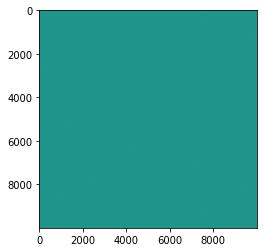

In [71]:
plt.imshow(np.log10(np.abs(out.get())))

In [2]:

def Initialize(screen):
    # must run this first
    # It modifies the screen dictionary in place.
    # Before calling this, you have to first define 
    #   screen['N'] == number of pixels across the screen, and
    #   screen['D'] == the physical length across the screen.
    # These two values are used to populate various new elements in the dictionary 
    # associated with the screen pixels and k-values of the FFT.
    #
    n = screen['N']
    xvec = np.linspace(0,screen['D'],n)
    screen['X'] = np.tile(xvec,(len(xvec),1))
    screen['Y'] = screen['X'].T #np.flipud(screen['X'].T)
    screen['E'] = np.ones((n,n))
    dk = 2*np.pi/screen['D'] #the separation in k-space corresponding to the separation in physical space
    screen['dk']=dk
    kvec = dk*np.fft.fftfreq(n)*n #largest k corresponds to smallest physical resolution on the aperture
    screen['kvec'] = kvec
    screen['kx']= np.fft.fftshift(np.tile(kvec,(kvec.size,1)))
    screen['ky']= screen['kx'].T #np.flipud(screen['kx'].T)
    screen['kap']= np.sqrt(screen['kx']**2 + screen['ky']**2)  # k vector in aperture plane (#radial distance at each point)

def MultByGaussian(screen, center, sigma):
    # center must be a tuple, (xcenter,ycenter)
    x0 = center[0]
    y0 = center[1]
    R = np.sqrt((screen['X']-x0)**2 + (screen['Y']-y0)**2)
    screen['E']=screen['E']*np.exp(-(R**2)/(2*sigma**2))
    
def InCircle(screen,center,radius):
    # Must have called makeXY first.
    # center must be a tuple, (xcenter,ycenter) in meters
    # radius in meters
    x0 = center[0]
    y0 = center[1]
    R = np.sqrt((screen['X']-x0)**2 + (screen['Y']-y0)**2)
    cut_ap = np.where(R<radius,1,0) # multiplication factor: in-circle: 1; out-circle: 0
    screen['E']=screen['E']*cut_ap

def CircleAtten(screen,center,radius,factor):
    x0 = center[0]
    y0 = center[1]
    R = np.sqrt((screen['X']-x0)**2 + (screen['Y']-y0)**2)
    atten_ap = np.where(R<radius,factor,1) #factor: multiplication factor of in-circle.
    screen['E']=screen['E']*atten_ap
    
def ScreenFFT(screen):
    screen['FFT_E'] = np.fft.fftshift(np.fft.fft2(screen['E']))
    screen['I'] = np.abs(screen['FFT_E'])**2

def Project_I_on_thetagrid(theta_vec,screen,lam):
    # Run after you've calculated the intensity as a function of kx, ky.
    # thetavec = 1D array of positions to be used for thetax, and for thetay
    #
    # Make 2D arrays of thetax, thetay coordinate for our map
    # We use the "_grid" suffix to indicate things that are 2D arrays associated
    # with the (new) thetax_grid, thetay_grid created next.
    N_thetagrid = len(theta_vec)
    thetax_grid, thetay_grid = np.meshgrid(theta_vec,theta_vec)
    #thetay_grid = np.flipud(thetay_grid)
    #
    kphot = 2*np.pi/lam    # photon k vector.
    #
    # Find kx and ky at each (thetax,thetay) grid spot
    #
    #kx_grid = kphot*thetax_grid/(np.pi/2) # fix this
    #ky_grid = kphot*thetay_grid/(np.pi/2)
    kx_grid = kphot*np.sin(thetax_grid)
    ky_grid = kphot*np.sin(thetay_grid)
    #
    # Now look at the original kx,ky map of our FT screen.
    #
    I_grid = np.zeros((N_thetagrid, N_thetagrid))
    
    dk = screen['kx'][0,1]-screen['kx'][0,0]
    for xx in range(N_thetagrid):
        for yy in range(N_thetagrid):
            kx = kx_grid[yy,xx]
            ky = ky_grid[yy,xx]
            #
            nx = kx/dk + screen['N']/2  # what element is this in the screen's kx,ky
            ny = ky/dk + screen['N']/2
            #
            # find the four values of kx,ky that surround
            nx1 = int(np.floor(nx))
            nx2 = int(np.ceil(nx))
            ny1 = int(np.floor(ny))
            ny2 = int(np.ceil(ny))
            # Go through four points surrounding our grid point's position and take weighted average.
            numsum = 0
            denomsum = 0
            for pt in [(nx1,ny1), (nx1,ny2), (nx2,ny1), (nx2,ny2)]:
                rr2 = (kx - screen['kx'][pt[0],pt[1]])**2 + (ky - screen['ky'][pt[0],pt[1]])**2
                w = 1/rr2
                numsum += w*screen['I'][pt[0],pt[1]]
                denomsum += w
                #
                #numsum += screen['I'][pt[0],pt[1]]
                #denomsum += 1
            I_grid[xx,yy] = numsum/denomsum
            #I_grid[xx,yy] = screen['I'][nx2,ny1]
        
    return I_grid



In [7]:
screen = {}
screen['N'] = 10000
screen['D'] = 10
Initialize(screen)
center = (screen['D']/2, screen['D']/2)
MultByGaussian(screen, center, 1.0)
#InCircle(screen, center, 2.0)
### TIME FFT
starttime = dt.datetime.now()
ScreenFFT(screen)
endtime = dt.datetime.now()
tt = (endtime-starttime).microseconds

#plt.imshow(screen['E'],extent=(0,screen['D'],screen['D'],0))
#plt.colorbar()
print(tt)

215746


In [10]:
#screen['FFT_E'] = np.fft.fftshift(np.fft.fft2(screen['E']))
#screen['I'] = np.abs(screen['FFT_E'])**2
starttime = dt.datetime.now()
E_gpu = cp.asarray(screen['E'])
#a = cp.random.random((100, 10000)).astype(cp.complex64)
plan = get_fft_plan(E_gpu, value_type='C2C')  # for batched, C2C, 2D transform
out = cupyx.scipy.fft.fft2(E_gpu, plan=plan)
with plan:
    # the arguments must match those used when generating the plan
    out = cp.fft.fft2(E_gpu)
endtime = dt.datetime.now()
tt = (endtime-starttime).microseconds
print(tt)

424290


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])